Transformer

In [1]:
"""Multi-head attention code"""
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1) # Cut off dimensions into 4D
    # number of heads, number of hiddens / number of heads
    X = X.permute(0, 2, 1, 3) # Transpose dimensions
    # batch * heads, sequence lengths
    return X.reshape(-1, X.shape[2], X.shape[3]) # 3D tensors

def transpose_output(X, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(
            self,
            key_size,
            query_size,
            value_size,
            num_hiddens,
            num_heads,
            dropout,
            bias=False,
            **kwargs
        ):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)         # dot product attention: there is no learnable weight w parameter
        # Fully connected layer (Linear layer)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)  # query
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)    # key
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)  # value
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias) # output

    def forward(self, queries, keys, values, valid_lens):
        # Put q, k, and v into weights w
        # Combine the dimensions of head and batch size
        # Put each projection of head into matrix multiplication
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # Mask elements after valid lengths: repeat elements of a tensor
            # Mask some paddings behind
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # Put 3D tensor to attention
        output = self.attention(queries, keys, values, valid_lens)
        # Convert 3D tensor back to 4D tensor, and then concatenate
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [6]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, dropout=0.5)
attention.eval()
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
X.shape, Y.shape, attention(X, Y, Y, valid_lens).shape

(torch.Size([2, 4, 100]), torch.Size([2, 6, 100]), torch.Size([2, 4, 100]))

In [7]:
"""Transformer code"""
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        # Two layers MLP (Single hidden layer + Single output layer)
        # When the input is not 2D, the dimensions before will be samples, later will be features
        return self.dense2(self.relu(self.dense1(X)))

In [9]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.4085,  0.5101, -0.3707,  0.4155, -0.2782,  0.2105, -0.8038,  0.7398],
        [-0.4085,  0.5101, -0.3707,  0.4155, -0.2782,  0.2105, -0.8038,  0.7398],
        [-0.4085,  0.5101, -0.3707,  0.4155, -0.2782,  0.2105, -0.8038,  0.7398]],
       grad_fn=<SelectBackward0>)

In [10]:
ln = nn.LayerNorm(2) # Layer normalization: mean=0, var=1, sample
bn = nn.BatchNorm1d(2) # Batch normalization: mean=0, var=1, batch
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [11]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X) # Residual connection: Y (output) + X (input)

In [12]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [32]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        # self.attention = d2l.MultiHeadAttention(
        #     key_size, 
        #     query_size,
        #     value_size, 
        #     num_hiddens,
        #     num_heads, 
        #     dropout, 
        #     use_bias
        # )
        self.attention = d2l.MultiHeadAttention(num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout, bias=use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, 
            ffn_num_hiddens,
            num_hiddens
        )
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        # Self attention mechanism: query = key = value = X (input)
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y)) # Put FFN(Y) and Y to AddNorm layer together (Residual connection)

In [33]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
# encoder_blk = EncoderBlock(key_size=24, query_size=24, value_size=24, num_hiddens=24, 
#                            norm_shape= [100, 24], ffn_num_input=24, 
#                            ffn_num_hiddens=48, num_heads=8, dropout=0.5)
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [34]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers): # Transformer block i
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(
                    key_size, query_size, value_size, num_hiddens,
                    norm_shape, ffn_num_input, ffn_num_hiddens,
                    num_heads, dropout, use_bias
                )
            )

    def forward(self, X, valid_lens, *args):
        # Position encoding = [-1, 1] interval
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) # d
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [35]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [38]:
class DecoderBlock(nn.Module):
    """i-th block in decoder"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        # self.attention1 = d2l.MultiHeadAttention(
        #     key_size, query_size,
        #     value_size, num_hiddens,
        #     num_heads, dropout
        # )
        self.attention1 = d2l.MultiHeadAttention(
            num_hiddens,
            num_heads, 
            dropout
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # self.attention2 = d2l.MultiHeadAttention(
        #     key_size, query_size,
        #     value_size, num_hiddens,
        #     num_heads, dropout
        # )
        self.attention2 = d2l.MultiHeadAttention(
            num_hiddens,
            num_heads, 
            dropout
        )
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, 
            ffn_num_hiddens, 
            num_hiddens
        )
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, 
                num_steps + 1,
                device=X.device
            ).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        X2 = self.attention1(X, key_values, key_values, dec_valid_lens) # Grab the input of decoder X
        Y = self.addnorm1(X, X2) # Add norm layer
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) # Pick up the outputs of encoder
        Z = self.addnorm2(Y, Y2) # Add norm layer
        return self.addnorm3(Z, self.ffn(Z)), state

In [39]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [40]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers): # Put all blocks (layers) inside
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(
                    key_size, query_size, value_size, num_hiddens,
                    norm_shape, ffn_num_input, ffn_num_hiddens,
                    num_heads, dropout, i
                )
            )
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.030, 7250.8 tokens/sec on cuda:0


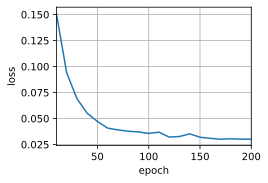

In [42]:
def sequence_mask(X, valid_len, value=0):
    """Disable unrelated items in sequence"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """Masked softmax cross entropy loss function"""
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train Seq2Seq model"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            # Y_hat, _ = net(X, dec_input, X_valid_len) # ValueError (expected 2)
            Y_hat = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
# d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [43]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est venu .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [44]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps)
)
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

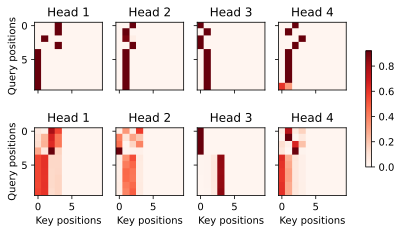

In [45]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), 
    xlabel='Key positions',
    ylabel='Query positions',
    titles=['Head %d' % i
    for i in range(1, 5)], figsize=(7, 3.5)
)

In [46]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

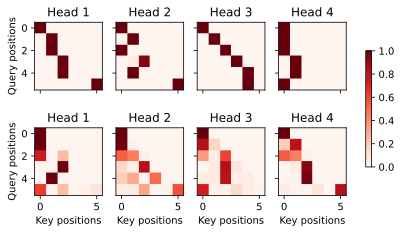

In [47]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5)
)

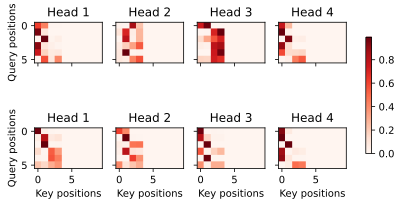

In [48]:
d2l.show_heatmaps(
    dec_inter_attention_weights, 
    xlabel='Key positions',
    ylabel='Query positions',
    titles=['Head %d' % i
    for i in range(1, 5)], 
    figsize=(7, 3.5)
)

In [49]:
"""Transformer: input shape = output shape"""

'Transformer: input shape = output shape'